In [1]:
# Import QICK libraries and extras

from qick import *

from tqdm import tqdm

import numpy as np
from numpy.fft import fft, fftshift

#%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
from qick.rfboard import RFQickSoc216V1


# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D
# for adding code snippets in loop exec_before/exec_after
from qick.asm_v2 import AsmV2

In [2]:
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host="pynq216-3.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
# print(soccfg)

soc = RFQickSoc216V1('../../fw/2024-09-28_216_tprocv2r21_rfb_standard/qick_216_rfb.bit', clk_output=None)
soccfg = soc

print(soccfg)


QICK running on ZCU216, software version 0.2.289

Firmware configuration (built Sat Sep 28 20:39:53 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_mixmux8_v1 - envelope memory 0 samples (0.000 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 

## Set channels according to QickSoc

In [3]:

FSGEN_CH = [0, 1, 2, 3]
DYNRO_CH = [0, 1]
INTGEN_CH = [15]

MIXMUXGEN_CH = 4
MUXRO_CH = [2,3,4,5,6,7,8,9]

### general notes
* In this firmware, generator numbers map directly to front-panel DAC port numbers. (This is not a fundamental rule, and we will eventually put the front-panel port numbers next to the JHC port numbers in the soccfg printout.)
* In this firmware, readouts 4-7 map to front-panel ADC ports 0-3; readouts 0-3 are multiplexed onto front-panel ADC port 4.
* In this firmware, the digital output pins from the tProc map to the first four User I/O SMA ports.

## Set RFBoard Attenuation

In [27]:
ch_config = {"res_ch"      : 15, #specialized MUX gen
        "q1_ch"       : 4,
        "q2_ch"       : 5,
        "q3_ch"       : 6,
        "q4_ch"       : 7,
        "ro_ch"       :[0, 1, 2, 3], #array of 4 ro channels (0-3)
            }

#qcenter_filter = [4810, 4710, 4551, 4720] #MHz #4708
qcenter_filter = [4909, 4749, 4569, 4759]

########################
### RF Board Setting ###
########################

#######
# DAC #
#######
freq = 6000 # Center of band pass filter, with bandwidth 1 GHz

# Set Filter.
soc.rfb_set_gen_filter(ch_config['res_ch'], fc=freq/1000, ftype='bandpass') #fc in GHz
#soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

soc.rfb_set_gen_filter(ch_config['q1_ch'], fc=qcenter_filter[0]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q2_ch'], fc=qcenter_filter[1]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q3_ch'], fc=qcenter_filter[2]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q4_ch'], fc=qcenter_filter[3]/1000, ftype='bandpass')

#set bandpass filter at where you know the qubit frequency is


# Set attenuator on DAC.
soc.rfb_set_gen_rf(ch_config['res_ch'], 8, 1)#25, 20)
# soc.rfb_set_gen_rf(ch_config['res_ch'], 8, 30)#25, 20)
soc.rfb_set_gen_rf(ch_config['q1_ch'], 5,5) # spec params are 20,15 for all 4 qubits
soc.rfb_set_gen_rf(ch_config['q2_ch'], 5,5) #(5,5)
soc.rfb_set_gen_rf(ch_config['q3_ch'], 5,5)
soc.rfb_set_gen_rf(ch_config['q4_ch'], 5,5) #(5,5)

#######
# ADC #
#######
# Set Filter.
soc.rfb_set_ro_filter(ch_config['ro_ch'][0], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(ch_config['ro_ch'][0], 15)

# Time of flight (decimated loopback)

{'steps': 1, 'gen_ch': 15, 'ro_ch': 0, 'freq': 500, 'nqz': 2, 'trig_time': 0.2, 'ro_len': 3, 'pulse_len': 1.5, 'phase': 0, 'gain': 1.0}


  0%|          | 0/100 [00:00<?, ?it/s]

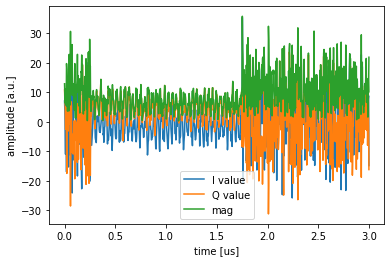

In [29]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=1000)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        # we need to make sure the readout gets reconfigured at the start of each frequency step
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        loopbefore = AsmV2()
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        loopbefore.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)

        self.add_loop("myloop", self.cfg["steps"], exec_before=loopbefore)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

CAL_FREQ = 500
CAL_RANGE = 0.1
DEBUG_CAL = False

# plot decimated to show that we're timed in
config = {'steps': 1,
          'gen_ch': 15,
          'ro_ch': 0,
          'freq': CAL_FREQ,
          'nqz': 2,
          'trig_time': 0.2,
          'ro_len': 3,
          'pulse_len': 1.5,
          'phase': 0,
          'gain': 1.0,
         }
print(config)
prog = FreqSweepProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="mag")
plt.ylabel("amplitude [a.u.]")
plt.xlabel("time [us]")
plt.legend();


In [ ]:
class MuxProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5,6,7],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': MIXMUXGEN_CH,
          'ro_chs': MUXRO_CH,
          'mixer_freq': 5000,
          'nqz': 2,
          'pulse_freqs': 5000+np.arange(8)*50,
          'pulse_gains': [1.0]*8,
          'pulse_phases': [0.0]*8,
          'ro_phases': [0.0]*8,
          'trig_time': 0.5,
          'pulse_len': 1.5,
          'ro_len': 2.0,
          # 'trig_time': 1.0,
          # 'pulse_len': 3.0,
          # 'ro_len': 2.5,
         }

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1, progress=False)
t = prog.get_time_axis(ro_index=0)

phases = [np.angle(iq.mean(axis=0).dot([1,1j]), deg=True) for iq in iq_list]
print("phase offsets:", phases)
config['pulse_phases'] = [-x for x in phases]

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

In [4]:
class MuxSGTest(AveragerProgram):
    def initialize(self):
        # Set up the multiplexed readout DAC.        
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg['gen_nqz'],
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['mux_gains'])     

        # DAC channel.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['res_ch'])
        self.set_pulse_registers(ch = self.cfg['res_ch'], style = 'const', length=length, mask=[0,1,2,3])

        # Readout.
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i], 
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['pulse_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
    
        self.synci(200)  # give processor some time to configure pulses
        
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['res_ch'], 
                 adcs            = self.ro_chs, #self.cfg['ro_ch'],
                 adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                 wait=True,
                 syncdelay       = self.us2cycles(self.cfg["relax_delay"]),
                 pins            = [0],
                 )

In [5]:
fcenter = [6187.1, 5828.32, 6600, 5959.25] #[6600, 5828.32, 6074.51, 5959.25] #[6187.1, 5827.6, 6074, 5958.5] #MHz

readout_cfg={
        "ro_length"   : 1, #4.7, #us    
        "ro_offset"   : 0.4, #0.5, #us
        "gen_nqz"     : 2, 
        "pulse_length": 0.5, #4.7, #us
        "mux_gains"  : [1, 1, 0, 1], #[0.85, 0.85, 0.85,0.85],# 0.5,1,1,1], #array of 4 gains - 1 is max output (range 0-1, fraction of max power)
       "pulse_freqs"  : fcenter,
        }

expt_cfg={"reps":1, 
          "soft_avgs": 1000, # Number of repetitions
          "relax_delay":20,
         }

config={**readout_cfg,**expt_cfg,**ch_config}

print(config)

{'ro_length': 1, 'ro_offset': 0.4, 'gen_nqz': 2, 'pulse_length': 0.5, 'mux_gains': [1, 1, 0, 1], 'pulse_freqs': [6187.1, 5828.32, 6600, 5959.25], 'reps': 1, 'soft_avgs': 1000, 'relax_delay': 20, 'res_ch': 15, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'ro_ch': [0, 1, 2, 3]}


In [6]:
# Run the script
tof=MuxSGTest(soccfg, config)
iq_list = tof.acquire_decimated(soc)

RuntimeError: tProc v1 programs can only be run on a tProc v1 firmware

In [ ]:
# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[0][0]
yq = iq_list[0][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[1][0]
yq = iq_list[1][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[2][0]
yq = iq_list[2][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[3][0]
yq = iq_list[3][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);

In [8]:
## Questions to work on

## With DAC attenuation of (8,30) + 40 dB attenuation, we see +/-3000 for signal and for noise
## With DAC attenuation of (8,10) + 40 dB attenuation, we see the edge of the pulse with 5000 averages.
## At NEXUS I'm concerned that our situation is actually like (8,30) + 20 dB attenuation (worst case fridge)
## and that we are saturating the ADC side of the RF board.

## 
## What does the FFT look like? 
## What is the "danger zone" as far as the settings for the DAC and ADC side attenuation?
## In this firmware, the digital output pins from the tProc map to the first four User I/O SMA ports. 


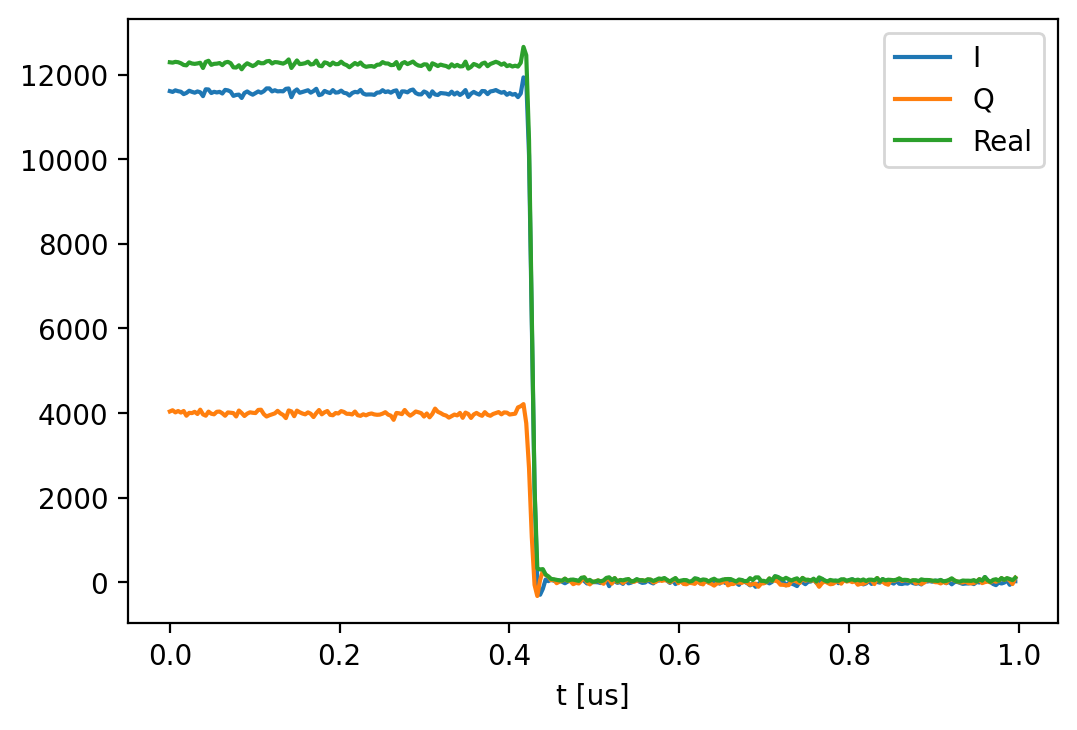

In [9]:
# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[0][0]
yq = iq_list[0][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

yr=np.sqrt(yi**2 + yq**2)


plt.plot(t,yi)
plt.plot(t,yq)
plt.plot(t,yr)
    
plt.xlabel('t [us]');
plt.legend(['I','Q','Real']);


(0.0, 1228.8)

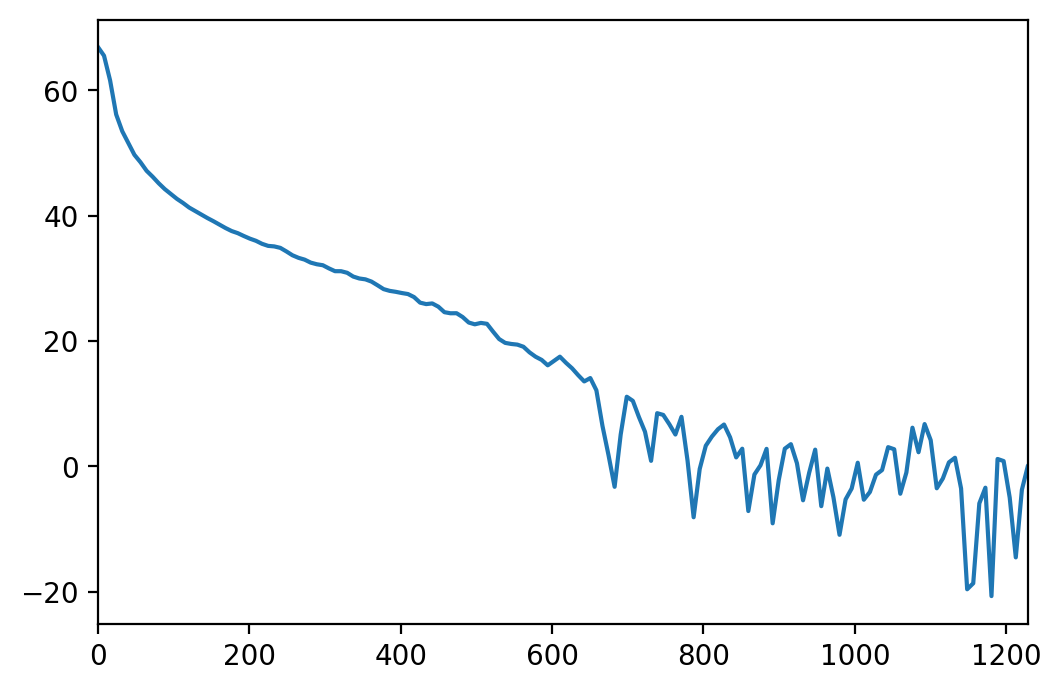

In [10]:
# Get data.
fs = 122.88*20
plt.figure(dpi=200)
x = yr

# Spectrum.
#x=x[1000:]
w = np.hanning(len(x))
xw = x*w
Y = fft(xw)/len(x)
YdB = 20*np.log10(np.abs(Y))
F = np.linspace(0,fs,len(Y))

#idx = np.argwhere((900 < F) & (F < 1100))
#minY = max(YdB[idx])
#maxY = max(YdB)
#snr = maxY - minY[0]
#print("SNR = {} dB".format(snr))

#plt.plot(F, 20*np.log10(np.abs(Y)/max(np.abs(Y))));
plt.plot(F, YdB);
#plt.plot(F, minY*np.ones(len(F)));
#plt.plot(F, maxY*np.ones(len(F)));
plt.xlim([0,fs/2])
#plt.ylim([-50,10]);
#plt.ylim([0,30]);

# Compute SNR

In [115]:
#Helper fit functions
from scipy.optimize import curve_fit

def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian_2d(data, maxfev=10000):
    x = data[:, 0]
    y = data[:, 1]
    
    # Improve initial guess
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_std, y_std = np.std(x), np.std(y)
    amplitude = np.max(data) - np.min(data)
    
    initial_guess = (amplitude, x_mean, y_mean, x_std, y_std, 0)
    
    # Add bounds to parameters
    lower_bounds = (0, np.min(x), np.min(y), 0, 0, -np.pi/2)
    upper_bounds = (np.inf, np.max(x), np.max(y), np.max(x)-np.min(x), np.max(y)-np.min(y), np.pi/2)
    
    try:
        popt, pcov = curve_fit(gaussian_2d, (x, y), np.ones_like(x), p0=initial_guess, 
                               bounds=(lower_bounds, upper_bounds), maxfev=maxfev)
        return popt, pcov
    except RuntimeError as e:
        print(f"Fitting failed: {str(e)}")
        return None, None

def plot_gaussian_2d(data, popt):
    if popt is None:
        print("Cannot plot: fitting failed")
        return
    
    x = data[:, 0]
    y = data[:, 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.scatter(x, y, alpha=0.5)
    ax1.set_xlabel('I (a.u.)')
    ax1.set_ylabel('Q (a.u.)')
    ax1.set_title('Original Data')
    
    x_range = np.linspace(min(x), max(x), 100)
    y_range = np.linspace(min(y), max(y), 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = gaussian_2d((X, Y), *popt).reshape(X.shape)
    
    ax2.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax2.set_xlabel('I (a.u.)')
    ax2.set_ylabel('Q (a.u.)')
    ax2.set_title('Fitted 2D Gaussian')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Amplitude: {popt[0]:.2f}")
    print(f"X0: {popt[1]:.2f}")
    print(f"Y0: {popt[2]:.2f}")
    print(f"Sigma X: {popt[3]:.2f}")
    print(f"Sigma Y: {popt[4]:.2f}")
    print(f"Theta: {popt[5]:.2f}")

In [116]:
class SingleShotProgram(AveragerProgram):
    def initialize(self):
        self.cfg["expts"]=1
        self.cfg["reps"]=self.cfg["shots"]

        # Set up the multiplexed readout DAC.        
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg['gen_nqz'],
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['mux_gains'])     

        # DAC channel.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['res_ch'])
        self.set_pulse_registers(ch = self.cfg['res_ch'], style = 'const', length=length, mask=[0,1,2,3])

        # Readout.
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i], 
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['pulse_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
    
        self.synci(200)  # give processor some time to configure pulses
        
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['res_ch'], 
                 adcs            = self.ro_chs, #self.cfg['ro_ch'],
                 adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                 wait=True,
                 syncdelay       = self.us2cycles(self.cfg["relax_delay"]),
                 pins            = [0],
                 )

    def acquire(self,soc, progress=False):
        super().acquire(soc, progress=progress)
        return self.collect_shots()
        
    def collect_shots(self):
        shots_i0=self.di_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0])
        shots_q0=self.dq_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0])
        return shots_i0,shots_q0

    def analyze(self, shots_i, shots_q):
        plt.subplot(111, xlabel='I', ylabel='Q', title='Single Shot Histogram')
        plt.plot(shots_i[0],shots_q[0],'.',label='g')
#         plt.plot(shots_i[1],shots_q[1],'.',label='e')
        plt.legend()
        plt.gca().set_aspect('equal', 'datalim')
        


The readout at 6600.000 MHz may see some crosstalk from the tone at 5828.320 MHz.
The readout at 5828.320 MHz may see some crosstalk from the tone at 6600.000 MHz.
The readout at 5959.250 MHz may see some crosstalk from the tone at 6187.100 MHz.
The readout at 5828.320 MHz may see some crosstalk from the tone at 5959.250 MHz.


{'ro_length': 1, 'ro_offset': 0.4, 'gen_nqz': 2, 'pulse_length': 0.5, 'mux_gains': [1, 0, 0, 0], 'pulse_freqs': [6187.1, 5828.32, 6600, 5959.25], 'reps': 1, 'relax_delay': 20, 'shots': 3000, 'res_phase': 0, 'res_ch': 15, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'ro_ch': [0, 1, 2, 3]}


  0%|          | 0/3000 [00:00<?, ?it/s]

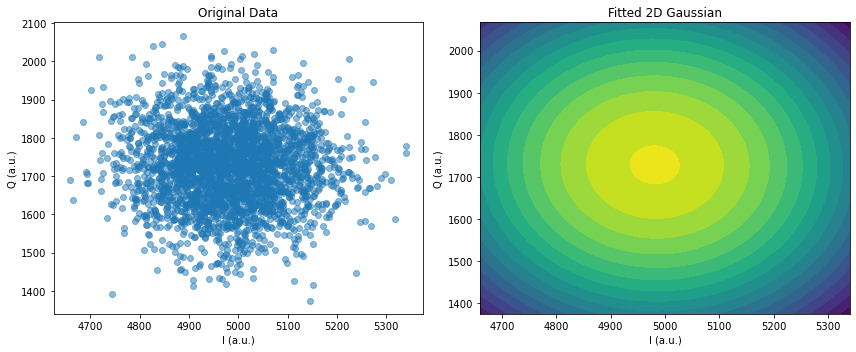

Amplitude: 1.02
X0: 4981.58
Y0: 1728.58
Sigma X: 680.56
Sigma Y: 692.18
Theta: -0.66


In [125]:
fcenter = [6187.1, 5828.32, 6600, 5959.25] #[6600, 5828.32, 6074.51, 5959.25] #[6187.1, 5827.6, 6074, 5958.5] #MHz

readout_cfg={
        "ro_length"   : 1, #4.7, #us    
        "ro_offset"   : 0.4, #0.5, #us
        "gen_nqz"     : 2, 
        "pulse_length": 0.5, #4.7, #us
        "mux_gains"  : [1, 0, 0, 0], #[0.85, 0.85, 0.85,0.85],# 0.5,1,1,1], #array of 4 gains - 1 is max output (range 0-1, fraction of max power)
       "pulse_freqs"  : fcenter,
        }

expt_cfg={"reps":1, 
          "relax_delay":20,
          "shots": 3000,
          "res_phase": 0
         }

config={**readout_cfg,**expt_cfg,**ch_config}
print(config)
ssp=SingleShotProgram(soccfg, config)
di0, dq0 = ssp.acquire(soc,progress=True)
# hist(data=[di0[0], dq0[0]],  plot=True, ran=600)
data = np.column_stack((di0[0], dq0[0]))  
popt, _ = fit_gaussian_2d(data)
if popt is not None:
    plot_gaussian_2d(data, popt)

# Test with filter set correctly

The readout at 6600.000 MHz may see some crosstalk from the tone at 5828.320 MHz.
The readout at 5828.320 MHz may see some crosstalk from the tone at 6600.000 MHz.
The readout at 5959.250 MHz may see some crosstalk from the tone at 6187.100 MHz.
The readout at 5828.320 MHz may see some crosstalk from the tone at 5959.250 MHz.


  0%|          | 0/3000 [00:00<?, ?it/s]

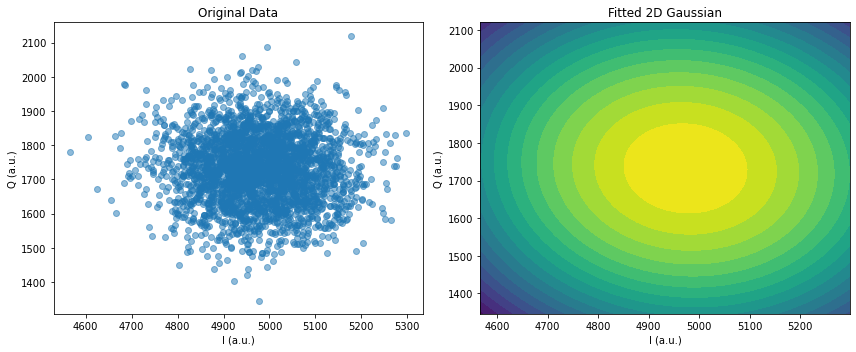

Amplitude: 1.02
X0: 4973.07
Y0: 1732.49
Sigma X: 731.07
Sigma Y: 774.46
Theta: -1.03


In [126]:
#######
# DAC #
#######
freq = 6000 # Center of band pass filter, with bandwidth 1 GHz

# Set Filter.
soc.rfb_set_gen_filter(ch_config['res_ch'], fc=freq/1000, ftype='bandpass') #fc in GHz

###
ssp=SingleShotProgram(soccfg, config)
di0, dq0 = ssp.acquire(soc,progress=True)
data = np.column_stack((di0[0], dq0[0]))  
popt, _ = fit_gaussian_2d(data)
if popt is not None:
    plot_gaussian_2d(data, popt)

# Test with filter not set correctly -- does the SNR decrease? I expect it to, but it doesn't, so that is confusing to me.

The readout at 6600.000 MHz may see some crosstalk from the tone at 5828.320 MHz.
The readout at 5828.320 MHz may see some crosstalk from the tone at 6600.000 MHz.
The readout at 5959.250 MHz may see some crosstalk from the tone at 6187.100 MHz.
The readout at 5828.320 MHz may see some crosstalk from the tone at 5959.250 MHz.


  0%|          | 0/3000 [00:00<?, ?it/s]

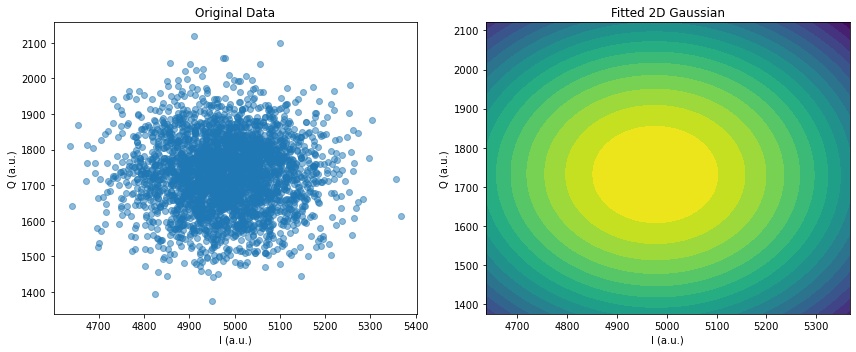

Amplitude: 1.02
X0: 4976.97
Y0: 1731.73
Sigma X: 730.04
Sigma Y: 744.72
Theta: -1.42


In [127]:
#######
# DAC #
#######
freq = 12000 # Center of band pass filter, with bandwidth 1 GHz

# Set Filter.
soc.rfb_set_gen_filter(ch_config['res_ch'], fc=freq/1000, ftype='bandpass') #fc in GHz

###
ssp=SingleShotProgram(soccfg, config)
di0, dq0 = ssp.acquire(soc,progress=True)
data = np.column_stack((di0[0], dq0[0]))  
popt, _ = fit_gaussian_2d(data)
if popt is not None:
    plot_gaussian_2d(data, popt)